### Fine Tuning Task  

강아지, 머핀 이진 분류  
https://drive.google.com/file/d/1Q_KC2nTmGlX2PeINWwV63_kpTjnoVpiO/view?usp=sharing

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_root = './datasets/muffin/original/'
test_root = './datasets/muffin/test/'

train_idg = ImageDataGenerator(rescale=1./255)
test_idg = ImageDataGenerator(rescale=1./255)

train_generator = train_idg.flow_from_directory(train_root, target_size=(150, 150), batch_size=32, class_mode='binary')
test_generator = test_idg.flow_from_directory(test_root, target_size=(150, 150), batch_size=32, class_mode='binary')

print(train_generator.class_indices)
print(test_generator.class_indices)

Found 4733 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.
{'chihuahua': 0, 'muffin': 1}
{'chihuahua': 0, 'muffin': 1}


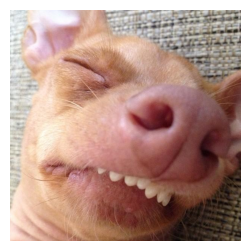

In [15]:
import cv2
import matplotlib.pyplot as plt

image = cv2.cvtColor(cv2.imread(train_generator.filepaths[1]), cv2.COLOR_BGR2RGB)

def show_image(image):
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

show_image(image)

In [16]:
target_name = {v: k for k, v in train_generator.class_indices.items()}
target_name

{0: 'chihuahua', 1: 'muffin'}

In [17]:
train_target_names = []
for target in train_generator.classes:
    train_target_names.append(target_name[target])

test_target_names = []
for target in test_generator.classes:
    test_target_names.append(target_name[target])

print(train_target_names.__len__(), test_target_names.__len__())

4733 1184


In [19]:
import pandas as pd

original_df = pd.DataFrame({'file_paths': train_generator.filepaths, 'target_names': train_target_names, 'targets': train_generator.classes})
original_df.loc[:, 'file_paths'] = original_df.file_paths.apply(lambda x: x.replace('\\', '/'))

test_df = pd.DataFrame({'file_paths': test_generator.filepaths, 'target_names': test_target_names, 'targets': test_generator.classes})
test_df.loc[:, 'file_paths'] = test_df.file_paths.apply(lambda x: x.replace('\\', '/'))

display(original_df)
display(test_df)

,file_paths,target_names,targets
0,./datasets/muffin/original/chihuahua/img_0_0.jpg,chihuahua,0
1,./datasets/muffin/original/chihuahua/img_0_1.jpg,chihuahua,0
2,./datasets/muffin/original/chihuahua/img_0_10.jpg,chihuahua,0
3,./datasets/muffin/original/chihuahua/img_0_100...,chihuahua,0
4,./datasets/muffin/original/chihuahua/img_0_100...,chihuahua,0
...,...,...,...
4728,./datasets/muffin/original/muffin/img_4_984.jpg,muffin,1
4729,./datasets/muffin/original/muffin/img_4_990.jpg,muffin,1
4730,./datasets/muffin/original/muffin/img_4_995.jpg,muffin,1
4731,./datasets/muffin/original/muffin/img_4_998.jpg,muffin,1


,file_paths,target_names,targets
0,./datasets/muffin/test/chihuahua/img_0_1071.jpg,chihuahua,0
1,./datasets/muffin/test/chihuahua/img_0_1074.jpg,chihuahua,0
2,./datasets/muffin/test/chihuahua/img_0_1082.jpg,chihuahua,0
3,./datasets/muffin/test/chihuahua/img_0_1087.jpg,chihuahua,0
4,./datasets/muffin/test/chihuahua/img_0_11.jpg,chihuahua,0
...,...,...,...
1179,./datasets/muffin/test/muffin/img_4_979.jpg,muffin,1
1180,./datasets/muffin/test/muffin/img_4_989.jpg,muffin,1
1181,./datasets/muffin/test/muffin/img_4_991.jpg,muffin,1
1182,./datasets/muffin/test/muffin/img_4_996.jpg,muffin,1


In [20]:
from sklearn.model_selection import train_test_split

train_images, validation_images, train_targets, validation_targets = \
train_test_split(original_df.file_paths, original_df.targets, stratify=original_df.targets, test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())

targets
0    2047
1    1739
Name: count, dtype: int64
targets
0    512
1    435
Name: count, dtype: int64


In [21]:
train_df = original_df.iloc[train_images.index].reset_index(drop=True)
validation_df = original_df.iloc[validation_images.index].reset_index(drop=True)

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(3786, 3)
(947, 3)
(1184, 3)


In [22]:
import shutil
import os

root = './datasets/muffin/'

for file_path in train_images:
    muffin_dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'train/' + muffin_dir)

    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)
    
for file_path in validation_images:
    muffin_dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'validation/' + muffin_dir)

    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)


In [23]:
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

IMAGE_SIZE = 224
BATCH_SIZE = 64

class Dataset(Sequence):
    def __init__(self, file_paths, targets, batch_size=BATCH_SIZE, aug=None, preprocess=None, shuffle=False):
        self.file_paths = file_paths
        self.targets = targets
        self.batch_size = batch_size
        self.aug = aug
        self.preprocess = preprocess
        self.shuffle = shuffle

        if self.shuffle:
            # epoch 종료 시, 객체 생성 및 데이터 섞기
            self.on_epoch_end()

    # __len__()는 전체 데이터 건수에서 batch_size 단위로 나눈 데이터 수
    # 예를 들어, 1000개의 데이터를 30 batch_size로 설정하면, 1 batch당 33.33... 개이다.
    # 이 때, 소수점은 무조건 올려서 33 + 1 = 34개로 설정한다.
    def __len__(self):
        return int(np.ceil(len(self.targets) / self.batch_size))

    # batch_size 단위로 이미지 배열과 타겟 데이터들을 가져온 뒤 변환한 값을 리턴한다.
    def __getitem__(self, index):
        file_paths_batch = self.file_paths[index * self.batch_size: (index + 1) * self.batch_size]
        targets_batch = self.targets[index * self.batch_size: (index + 1) * self.batch_size]

        results_batch = np.zeros((file_paths_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

        for i in range(file_paths_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(file_paths_batch[i]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

            if self.aug is not None:
                image = self.aug(image=image)['image']

            if self.preprocess is not None:
                image = self.preprocess(image)

            results_batch[i] = image

        return results_batch, targets_batch

    def on_epoch_end(self):
        if self.shuffle:
            self.file_paths, self.targets = shuffle(self.file_paths, self.targets)
            

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(2, activation='sigmoid', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)

    if verbose:
        model.summary()
    else:
        pass

    return model

In [36]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import layers

IMAGE_SIZE = 224
BATCH_SIZE = 64

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 10
    
    train_file_paths, train_targets, validation_file_paths, validation_targets, test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, train_targets, batch_size=BATCH_SIZE, aug=aug, preprocess=xception_preprocess_input, shuffle=True)
    validation_dataset = Dataset(validation_file_paths, validation_targets, batch_size=BATCH_SIZE, preprocess=xception_preprocess_input)

    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['acc'])

    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-5]:
        layer.trainable = False

    model.fit(train_dataset, batch_size=BATCH_SIZE, epochs=FIRST_EPOCHS, validation_data=validation_dataset)

    # 배치 정규화만 freeze 진행
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    model.compile(optimizer=Adam(0.00001), loss=BinaryCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset, batch_size=BATCH_SIZE, epochs=SECOND_EPOCHS, validation_data=validation_dataset)

    return model, history

In [37]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input

train_file_paths = train_df['file_paths'].values
train_targets = pd.get_dummies(train_df['targets']).values # CategoricalCrossEntropy

validation_file_paths = validation_df['file_paths'].values
validation_targets = pd.get_dummies(validation_df['targets']).values # CategoricalCrossEntropy

test_file_paths = test_df['file_paths'].values
test_targets = pd.get_dummies(test_df['targets']).values # CategoricalCrossEntropy

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

model, history = fine_tune((train_file_paths, train_targets,
           validation_file_paths, validation_targets,
           test_file_paths, test_targets),
          'mobilenet', 
          aug,
          mobilenet_preprocess_input)

C:\Users\hyuns\AppData\Local\Temp\ipykernel_2896\750579485.py:17: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,322,136 (8.86 MB)

 Trainable params: 2,288,024 (8.73 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/10


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - acc: 0.8594 - loss: 0.3461 - val_acc: 0.9926 - val_loss: 0.0329
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - acc: 0.9722 - loss: 0.0788 - val_acc: 0.9926 - val_loss: 0.0286
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - acc: 0.9856 - loss: 0.0521 - val_acc: 0.9947 - val_loss: 0.0262
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - acc: 0.9860 - loss: 0.0392 - val_acc: 0.9947 - val_loss: 0.0263
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - acc: 0.9904 - loss: 0.0331 - val_acc: 0.9937 - val_loss: 0.0282
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - acc: 0.9884 - loss: 0.0397 - val_acc: 0.9937 - val_loss: 0.0265
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - acc: 0.9882 - loss: 0.0337 - val_acc: 0.9947 - val_loss: 0.0262
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - acc: 0.9870 - loss: 0.0343 - val_acc: 0.9958 - val_loss: 0.0237
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - acc: 0.9891 - loss: 0.0307 - v

In [38]:
test_dataset = Dataset(test_file_paths, test_targets, batch_size=BATCH_SIZE, preprocess=xception_preprocess_input)

model.evaluate(test_dataset, batch_size=BATCH_SIZE)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 946ms/step - acc: 0.9951 - loss: 0.0111


[0.00688355416059494, 0.9966216087341309]

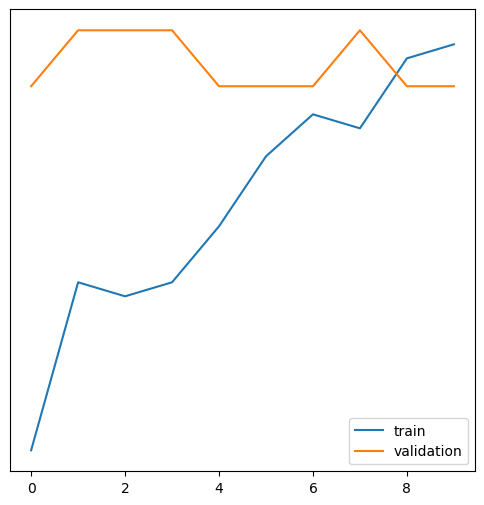

In [39]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    plt.show()

show_history(history)